# Convolutional Neural Networks - Step By Step

## Import Modules

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)


## GOALS

We will be implementing the building blocks of a convlutional neural network.

Note that for every forward function, there is a corresponding backward equivalent, hence , at every step of your forward module you will store some parameters in a cache. These parameters are used to compute gradients during backpropagation.

### Convolution Neural Networks

although programming frameworks make convolutions easy to use, they remain one of the hardest concepts in DL.

A Convolution layer transforms an input volume into an output volume of different size

We will build every step of the convolution layer in this notebook, First, we will implement two helper functions, one for zero padding and the other for computing the convolution function itself.

### Zero Padding

zero-padding adds zeros around the border of an image

The main benfits of padding are

- It allows you to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deep neural networks, since otherwise the height and width would shrink as you go to deeper layers, An important special case is the same convolution, in which the height/width is exactly preserved after one layer.

- It helps us keep more of the information at the border of an image. without padding, very few values at the next layer would be affected by pixels as the edges of an image

Now, we implement the function, which pads all the images of a batch of examples X with zeros. use np.pad. Note if you want to pad the array a of shape (5,5,5,5,5) with pad = 1 for the 2nd dimension, pad = 3 for the 4th dimension and pad = 0 for the rest, you would do it using the following code

a = np.pad(a,((0,0),(1,1),(0,0),(3,3),(0,0)), mode='constant', constant_values=(0,0))

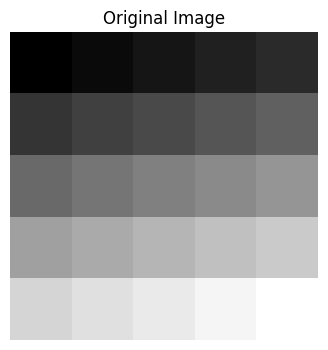

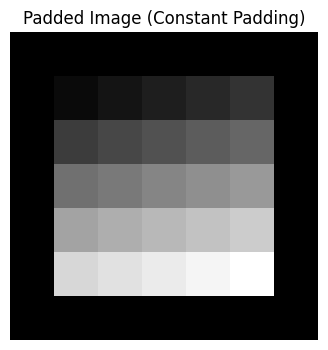

In [27]:
# Let`s First understand padding using a visual representation


# Create a 5x5 image (2D array)
image = np.array([[1, 2, 3, 4, 5],
                  [6, 7, 8, 9, 10],
                  [11, 12, 13, 14, 15],
                  [16, 17, 18, 19, 20],
                  [21, 22, 23, 24, 25]])


# Display the original image
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

# Pad the image with a constant value of 0
padded_image = np.pad(image, pad_width=1, mode='constant', constant_values=0)


# Display the padded image
plt.imshow(padded_image, cmap='gray')
plt.title("Padded Image (Constant Padding)")
plt.axis('off')
plt.show()

In [40]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    X_pad = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)), mode='constant', constant_values = (0,0))
    
    return X_pad

x.shape - (4, 3, 3, 2)
x_pad.shape - (4, 5, 5, 2)
x[1,1] 
  [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] 
 [[ 0.          0.        ]
 [ 0.04221375  0.58281521]
 [-1.10061918  1.14472371]
 [ 0.90159072  0.50249434]
 [ 0.          0.        ]]


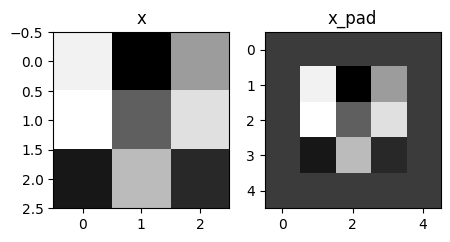

In [24]:
np.random.seed(1)

x = np.random.randn(4,3,3,2)
x_pad = zero_pad(x,1)

print ("x.shape -", x.shape)
print ("x_pad.shape -", x_pad.shape)
print ("x[1,1] \n ", x[1,1])
print ("x_pad[1,1] \n", x_pad[1,1])

# plot both the arrays
fig, axarr = plt.subplots(1,2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

### Single Step of Convolution

Now, We`ll implement a single step of convolution, in which you apply the filter to a single position of the input. This will be used to build a convolutional unit, which
- takes an input volume
- applies a filter at every position of the input
- outputs anothet volume

In a computer vision application, each value in the matrix on the left corresponds to a single pixel value, and we convolve a 3*3 matrix filter with the image by multiplying its values element wise with the original matrix, then summing them up and adding a bias.

Now, we implement a single step of convolution, corresponding to applying a filter to just one of the positions to get a single real-valued output.

NOTE - the variable b will be passed in as a numpy array, If we add a scalar to a numpy array, the result is a numpy array.

In [31]:

def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """

    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    s = np.multiply(a_slice_prev, W)
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = Z + float(b)

    return Z

In [37]:
np.random.seed(1)
a_slice_prev = np.random.randn(4,4,3)
W = np.random.randn(4,4,3)
b = np.random.randn(1,1,1)

Z = conv_single_step(a_slice_prev,W,b)
print('Z=',Z)

Z= -6.999089450680221


### Convolutional Neural Networks - Forward Pass

In the forward pass, you will take many filters and convolve them on the input. Each convolution gives you a 2D matrix output. You will then stack these outputs to get a 3D volume.

Now, We implement a function below to convolve the filters W on an input activation A_prev. This function takes the following inputs
- A_prev, the activations output by the previous layer.
- weights are denoted by W. The filter window size is f by f.
- the bias vector is b, where each filter has its own bias.

Also, we have access to the hyperparameters dictionary which contains the stride and the padding.

NOTE-
To Select a 2*2 slice at the upper left corner of a matrix "a_prev" (shape(5,5,3)), you would do:

```python
a_slice_prev = a_prev[0:2,0:2,:]
```

Notice, how this gives a 3d slice that has height 2, width 2, and depth 3. Depth is the number of channels. This will be useful when you will define `a_slice_prev` below, using the start/end indexes. To Define a_slice you will need to first define its corners vert_start, vert_end, horiz_start, horiz_end.

NOTE-
for now, we won`t worry about vectorization, and will just implement everything with for loops.

In [42]:
# now we implement the forward propagation of the convolution network

def conv_forward(A_prev, W, b, hparameters):
    """
    Arguments:
    A_prev -- output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    

    # Retrieve dimensions from input shapes. this allows us to know how many dimensions and filters we have.
    # retrieve dimensions from A_prev`s shape
    m = A_prev.shape[0]
    n_H_prev = A_prev.shape[1]
    n_W_prev = A_prev.shape[2]
    n_C_prev = A_prev.shape[3]

    # retrieve dimensions from W`s shape
    (f, f, n_C_prev, n_C) = W.shape[0], W.shape[1], W.shape[2], W.shape[3]

    # Retrieve hyperparameters
    stride = hparameters["stride"]
    pad = hparameters["pad"]

    # Compute output dimensions.
    # Calculates the height(`n_H`) and width(`n_W`) of the output feature map using the formula for convolutional layers
    n_H = int(int(n_H_prev + 2*pad - f) / stride + 1) 
    n_W = int(int(n_W_prev + 2*pad - f) / stride + 1)

    # Initialize output volume `Z`
    # Initializes an output volume `Z` with zeros that will store the results of the convolution operation
    Z = np.zeros([m, n_H, n_W, n_C])

    # Pad input activations
    # pads the input activations `A_prev` using a helper function `zero_pad`, which adds zeros around the input volume based on specified padding.
    A_prev_pad = zero_pad(A_prev, pad)

    # Loop over training examples
    # loop over each training example in the batch
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        
        for h in range(n_H):
            # for each height position in the output volume, calculate where to start and end
            # slicing in the padded activation map
            vertical_start = stride * h
            vertical_end = vertical_start + f

            for w in range(n_W):
                # similar to height, calculates horizontal start and end positions for scaling
                horizontal_start = stride * w
                horizontal_end = horizontal_start + f
                
                for c in range(n_C): # loop over output volumes
                    a_slice_prev = A_prev_pad[i, vertical_start:vertical_end, horizontal_start:horizontal_end, :] # slices out a portion of `A_prev_pad` corresponding to the current filter`s receptive field

                    # convolution_operation
                    weights = W[:, :, :, c]
                    biases = b[:, :, :, c]
                    # calls a helper function `conv_single_step`, which performs the actual convolution operation between the sliced input and filter weights plus bias.
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)

    # ensures that the output shape is correct before returning it
    assert(Z.shape == (m, n_H, n_W, n_C))

    # saves necessary variables for use during backpropagation
    cache = (A_prev, W, b, hparameters)

    return Z, cache

In [41]:
np.random.seed(1)
A_prev = np.random.randn(10,5,7,4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

Z's mean =
 0.6923608807576932
Z[3,2,1] =
 [-1.28912231  2.27650251  6.61941931  0.95527176  8.25132576  2.31329639
 13.00689405  2.34576051]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


### Pooling Layer

The pooling layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input.
The two types of pooling layers are:

- Max-pooling layer: slides an (f,f) window over the input and stores the nax value of the window in the output.
- Average-pooling layer: slides an (f,f) window over the input and stores the average of the window in the output.

These pooling layers have no parameters for backpropagation to train. However, they have parameters such as window size f. This specifies the height and width of the f*f window you would compute a max or average over.

#### Forward Pooling

Now, you are going to implement Max-pool and Average-pool, in the same function.

In [43]:
def pool_forward(A_prev,hparameters, mode='max'):
    """
    Implements then forward pass of the pooling layer

    Argument:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing `f` and `stride`
    mode -- the pooling mode you would like to use, i.e max or average

    Returns:
    A -- output of the pool layer, a numpy array of shape(m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains input and hparameters
    """
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]

    # Define the dimensions of the output 
    n_H = int(1 + (n_H_prev - f) / stride) # calculates the height(`n_H`) of the output feature map using the formula for pooling layers
    n_W = int(1 + (n_W_prev - f) / stride) # calculates the width(`n_W`) of the output feature map using the formula for pooling layers
    n_C = n_C_prev # the number of channels remains the same as in the input

    # Initialize Output matrix
    A = np.zeros((m, n_H, n_W, n_C)) # will store results after pooling operations

    # Loop over training examples in batch
    for i in range(m):
        
        # loop over output height
        for h in range(n_H):
            # for each height position in the output volume, calculate where to start and end slicing in the input activationmap based on stride and filter
            vertical_start = stride * h
            vertical_end = vertical_start + f
            
            # loop over output width
            for w in range(n_W):
                # similar to height, calculates horizontal start and end positions for slicing based on stride and filter size
                horizontal_start = stride * w
                horizontal_end = horizontal_start + f
                
                # loop over channels
                for c in range(n_C):
                    a_prev_slice = A_prev[i] # selects the corresponding input activation for the current training example `i`
                    
                    # Compute Pooling Operation
                    # Depending on whether max or average pooling is specified:
                    # For max pooling: computes the maximum value within the defined slice
                    # For average pooling: computes the average value within the defined slice
                    # the result is stored in A[i, h, w, c]
                    if mode == 'max':
                        A[i, h, w, c] = np.max(a_prev_slice[vertical_start:vertical_end,horizontal_start:horizontal_end,c])
                    elif mode == 'average':
                        A[i, h, w, c] = np.mean(a_prev_slice[vertical_start:vertical_end,horizontal_start:horizontal_end,c])

    # saves necessary variables for use during backpropagation
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))

    return A, cache

In [44]:
# Case 1: stride of 1
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.46210794 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.14472371 0.90159072 2.10025514]
   [1.14472371 0.90159072 1.65980218]
   [1.14472371 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 0.84616065 1.2245077 ]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.84616065 1.27375593]
   [1.96710175 0.84616065 1.23616403]
   [1.62765075 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.96710175 0.86888616 1.23616403]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[-3.01046719e-02 -3.24021315e-03 -3.36298859e-01]
   [ 1.43310483e-01  1.93146751e-01 -4.44905196e-01]
   [ 1.28934436e-01  2.22428468e-01  1.25067597e-01]]

  [[-3.81801899e-01  1.59993515e-02  1.70562706e-01]
   [

In [45]:
# Case 2: stride of 2
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 2, 2, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 2, 2, 3)
A =
 [[[[-0.03010467 -0.00324021 -0.33629886]
   [ 0.12893444  0.22242847  0.1250676 ]]

  [[-0.38268052  0.23257995  0.6259979 ]
   [-0.09525515  0.268511    0.46605637]]]


 [[[-0.17313416  0.32377198 -0.34317572]
   [ 0.02030094  0.14141479 -0.01231585]]

  [[ 0.42944926  0.08446996 -0.27290905]
   [ 0.15077452  0.28911175  0.00123239]]]]


Congratulations! You have now implemented the forward passes of all the layers of a convolutional network. 